In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

flights_df = pd.read_csv('M1_final.csv')
flights_df['Dew Point'] = flights_df['Dew Point'].astype('int64')

In [2]:
pd.set_option('display.max_columns', None)

flights_df

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,DEP_TIME_M,CRS_ARR_M,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,323,448,48,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,333,531,48,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,341,482,48,34,58,W,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,N999JQ,MCO,-2,168,944,345,343,513,48,34,58,W,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,N880DN,ATL,-4,139,760,360,356,499,46,32,58,W,24,35,29.91,Fair / Windy,9,17,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28815,1,31,5,B6,N216JB,ORH,2,57,150,1370,1372,1427,39,38,96,N,6,0,30.18,Cloudy,20,32,19
28816,1,31,5,AA,N104NN,BOS,2,75,187,1390,1392,25,39,38,96,N,6,0,30.18,Cloudy,19,23,22
28817,1,31,5,AS,N581AS,SEA,283,392,2422,1125,1408,1337,39,38,96,N,6,0,30.18,Cloudy,19,23,21
28818,1,31,5,B6,N957JB,SJU,5,224,1598,1417,1422,261,39,38,96,N,6,0,30.18,Cloudy,19,23,13


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def find_year(row):
    if row == 1:
        return 2020
    return 2019

def remove_windy(row):
    string = ' / Windy'
    if row[-8:] == string:
        return row[:-8]
    return row

datetime_dict = {'YEAR': 'year', 'MONTH': 'month', 'DAY_OF_MONTH': 'day'}
week_dict = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
test_df = flights_df.copy()
year = test_df['MONTH'].apply(find_year)
test_df.insert(0, 'YEAR', year)
date = pd.to_datetime(test_df[['YEAR', 'MONTH', 'DAY_OF_MONTH']].rename(columns=datetime_dict))
test_df.insert(0, 'DATE', date)
test_df = test_df.drop(['YEAR', 'MONTH', 'DAY_OF_MONTH'], axis=1)
test_df['DAY_OF_WEEK'] = test_df['DAY_OF_WEEK'].replace(week_dict)
test_df['Condition'] = test_df['Condition'].apply(remove_windy)
test_df = test_df.fillna('CALM')
week_encoded = pd.get_dummies(test_df['DAY_OF_WEEK'], dtype='int64').drop(['Mon'], axis=1)
carrier_encoded = pd.get_dummies(test_df['OP_UNIQUE_CARRIER'], dtype='int64').drop(['B6'], axis=1)
dest_encoded = pd.get_dummies(test_df['DEST'], dtype='int64').drop(['LAX'], axis=1)
wind_encoded = pd.get_dummies(test_df['Wind'], dtype='int64').drop(['CALM'], axis=1)
condition_encoded = pd.get_dummies(test_df['Condition'], dtype='int64').drop(['Fair'], axis=1)
test_df = pd.concat([test_df, week_encoded, carrier_encoded, dest_encoded, condition_encoded, wind_encoded], axis=1)
test_df.loc[test_df.Humidity == 0, 'Dew Point'] = 46

regression_df = test_df[~test_df.Humidity.isin([0,10])]

X = np.array(regression_df[['Temperature', 'Dew Point']])
y = np.array(regression_df['Humidity'])

poly = PolynomialFeatures(degree=3)
poly_X = poly.fit_transform(X)

model = LinearRegression()
model.fit(poly_X, y)

humidity_df = test_df[test_df.Humidity.isin([0,10])]

X = np.array(humidity_df[['Temperature', 'Dew Point']])
poly_X = poly.transform(X)
y = np.around(model.predict(poly_X))

test_df.loc[test_df.Humidity.isin([0,10]), 'Humidity'] = y

In [4]:
regression_df = test_df.loc[test_df.Humidity != 0]

X = np.array(regression_df.loc(axis=1)['Temperature', 'Pressure', 'Wind Speed', *wind_encoded.columns])
y = np.array(regression_df['Dew Point'])

model = LinearRegression()
model.fit(X, y)

X = np.array(regression_df.loc(axis=1)['Temperature', 'Pressure', 'Wind Speed', *wind_encoded.columns])
y_pred = model.predict(X)

# sns.residplot(x=y, y=y_pred, scatter_kws={"s": 10})

In [5]:
from sklearn.preprocessing import PowerTransformer

feature_df = test_df.drop([
    'DATE',
    'DAY_OF_WEEK',
    'OP_UNIQUE_CARRIER',
    'TAIL_NUM',
    'DEST',
    'DISTANCE',
    'CRS_DEP_M',
    'CRS_ARR_M',
    'Dew Point',
    'Wind Gust',
    'Wind',
    'Condition',
    'TAXI_OUT'
], axis=1)

target_df = test_df['TAXI_OUT']

In [6]:
from sklearn.model_selection import train_test_split

X_transformer = PowerTransformer()
y_transformer = PowerTransformer()
poly = PolynomialFeatures(degree=4)

X = np.array(feature_df)
y = np.array(target_df).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_transformed = np.hstack((X_transformer.fit_transform(X_train[:,:7]), X_train[:,7:]))
poly_X_train = np.hstack((poly.fit_transform(X_train_transformed[:,:7]), X_train_transformed[:,7:]))
y_train_tranformed = y_transformer.fit_transform(y_train)

X_test_transformed = np.hstack((X_transformer.transform(X_test[:,:7]), X_test[:,7:]))
poly_X_test = np.hstack((poly.transform(X_test_transformed[:,:7]), X_test_transformed[:,7:]))
y_test_transformed = y_transformer.transform(y_test)

linear_model = LinearRegression()
linear_model.fit(X_train_transformed, y_train_tranformed)
linear_model.score(X_test_transformed, y_test_transformed)

0.13646740443349525

<Axes: >

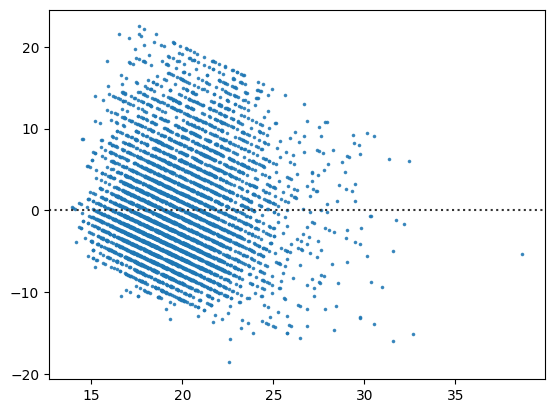

In [7]:
y_pred_transformed = linear_model.predict(X_test_transformed)
y_pred = y_transformer.inverse_transform(y_pred_transformed)

sns.residplot(x=y_pred, y=y_test, scatter_kws={'marker': '.', 's':10})